           MMM       AOS       ABT      ABBV      ABMD       ACN      ATVI  \
MMM   1.000000  0.982680  0.850853  0.816295  0.836678  0.905303  0.920246   
AOS   0.982680  1.000000  0.874400  0.854653  0.871523  0.929858  0.952686   
ABT   0.850853  0.874400  1.000000  0.829366  0.856358  0.981084  0.915380   
ABBV  0.816295  0.854653  0.829366  1.000000  0.861629  0.889054  0.923882   
ABMD  0.836678  0.871523  0.856358  0.861629  1.000000  0.880320  0.907604   

           ADM      ADBE       ADP  ...       WTW       GWW      WYNN  \
MMM   0.876377  0.771596  0.904604  ...  0.895320  0.888082  0.732382   
AOS   0.836977  0.818193  0.925825  ...  0.906182  0.879257  0.673203   
ABT   0.791363  0.967270  0.968353  ...  0.964493  0.902443  0.563101   
ABBV  0.655648  0.861237  0.855061  ...  0.855617  0.695131  0.024014   
ABMD  0.675450  0.874047  0.893603  ...  0.836566  0.772463  0.502015   

           XEL       XYL       YUM      ZBRA       ZBH      ZION       ZTS  
MMM   0.892711 

ValueError: The number of FixedLocator locations (503), usually from a call to set_ticks, does not match the number of ticklabels (502).

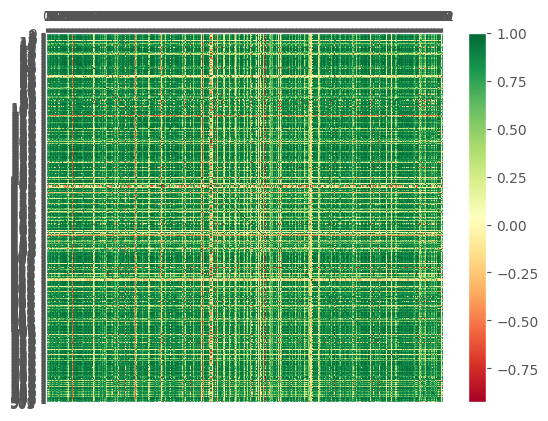

In [64]:
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd 
import pickle
import requests
import yfinance as yf

style.use('ggplot')

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html.parser')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = [row.find('td').text.strip().replace('.', '-') for row in table.find_all('tr')[1:]]
    
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
    return tickers

def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2020, 11, 26)

    for ticker in tickers:
        if not os.path.exists(f'stock_dfs/{ticker}.csv'):
            df = yf.download(ticker, start, end)
            df.reset_index(inplace=True)
            df.set_index('Date', inplace=True)
            df.to_csv(f'stock_dfs/{ticker}.csv')
        else:
            print(f'Already have {ticker}')

def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns ={'Adj Close': ticker}, inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace=True )
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
            
        if count % 10 == 0:
            print(count)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
    
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
#     df['AAPL'].plot()
#     plt.show()

    df_corr = df.corr()
    print(df_corr.head())
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]))
    ax.set_yticks(np.arange(data.shape[1] + 0.5))
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    columns_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(columns_labels[:-1])
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout
    plt.show()
visualize_data()
